In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.model_selection import train_test_split

IMG_SIZE = 256
BASE_DIR = r"C:\Users\K KIRAN KUMAR\OneDrive\DL_verse\archive"
IMAGE_DIR = os.path.join(BASE_DIR, "EX")
MASK_DIR  = os.path.join(BASE_DIR, "Annotation_EX")

In [9]:
def load_and_preprocess(img_dir, mask_dir):
    images, masks = [], []
    img_list = sorted(os.listdir(img_dir))
    mask_list = sorted(os.listdir(mask_dir))

    for i in range(len(img_list)):
        # Load image and scale to 0-1
        img = cv2.imread(os.path.join(img_dir, img_list[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img / 255.0) 
        
        # Load mask and ensure it is binary (0 or 1)
        mask = cv2.imread(os.path.join(mask_dir, mask_list[i]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        masks.append((mask > 0).astype(np.float32))

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

X, y = load_and_preprocess(IMAGE_DIR, MASK_DIR)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [10]:
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [11]:
def build_robust_unet():
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = layers.BatchNormalization()(b)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b)
    m1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(m1)
    c3 = layers.BatchNormalization()(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    m2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(m2)
    c4 = layers.BatchNormalization()(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)
    return models.Model(inputs, outputs)

model = build_robust_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])

In [12]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=4)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - dice_coef: 0.0108 - loss: 0.9892 - val_dice_coef: 0.0051 - val_loss: 0.9949
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - dice_coef: 0.0109 - loss: 0.9892 - val_dice_coef: 0.0052 - val_loss: 0.9948
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice_coef: 0.0120 - loss: 0.9880 - val_dice_coef: 0.0053 - val_loss: 0.9947
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - dice_coef: 0.0111 - loss: 0.9889 - val_dice_coef: 0.0053 - val_loss: 0.9947
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - dice_coef: 0.0138 - loss: 0.9862 - val_dice_coef: 0.0053 - val_loss: 0.9947
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - dice_coef: 0.0122 - loss: 0.9879 - val_dice_coef: 0.0052 - val_loss: 0.9948
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - dice_coef: 0.0128 - loss: 0.9873 - val_dice_coef: 0.0052 - val_loss: 0.9948
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - dice_coef: 0.0133 - loss: 0.9867 - val_dice_

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


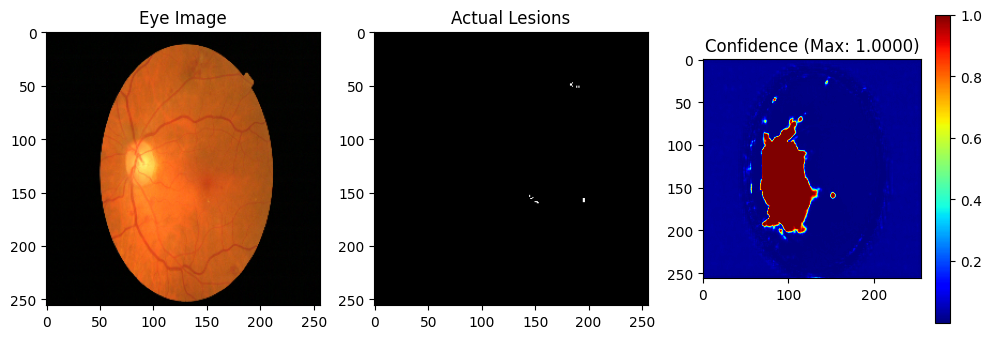

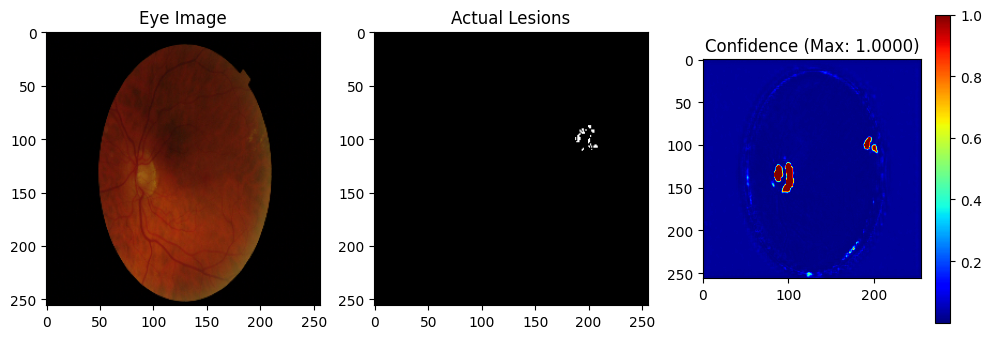

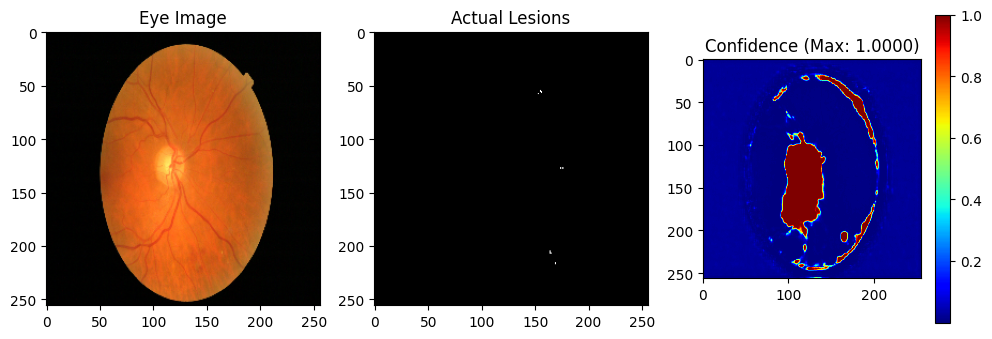

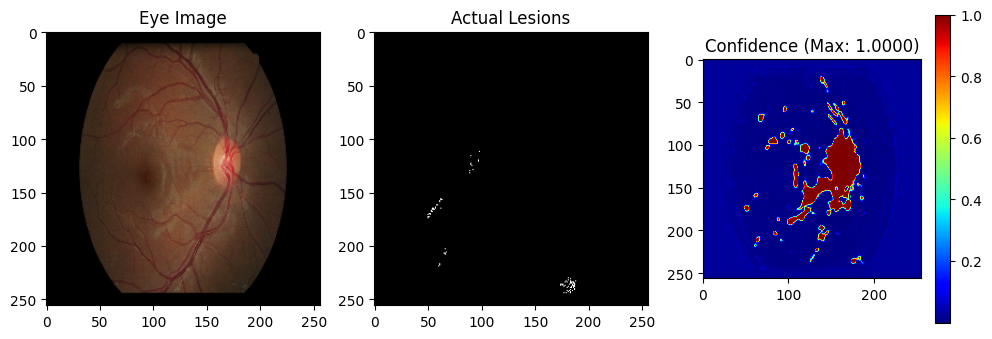

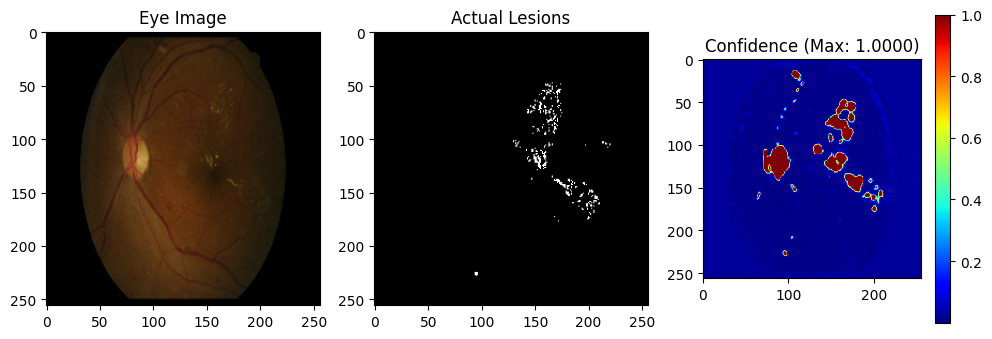

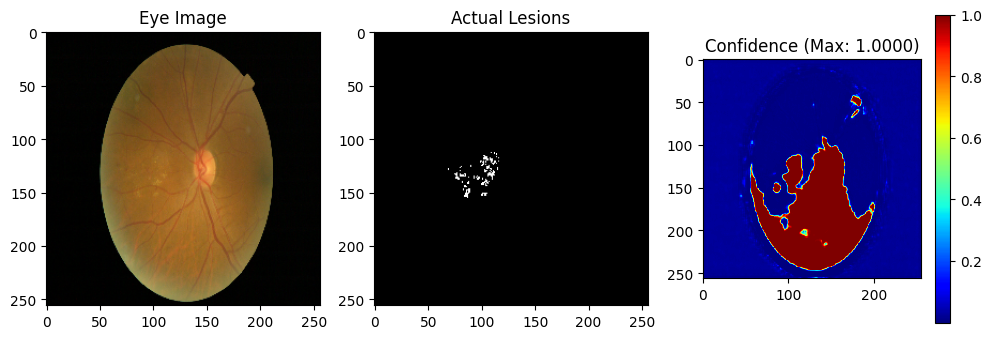

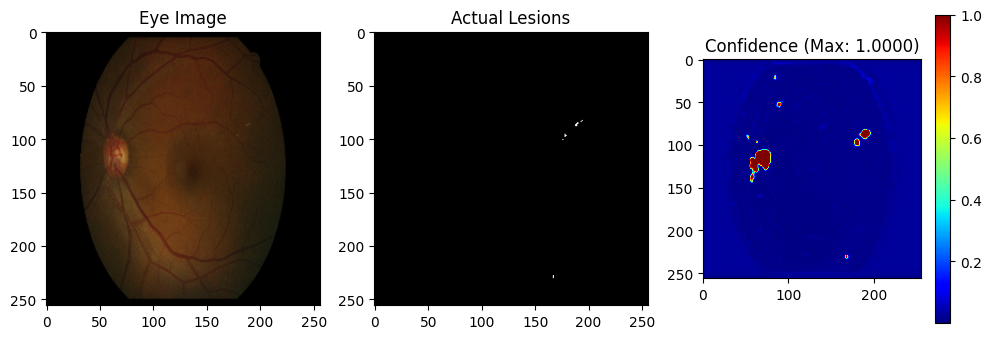

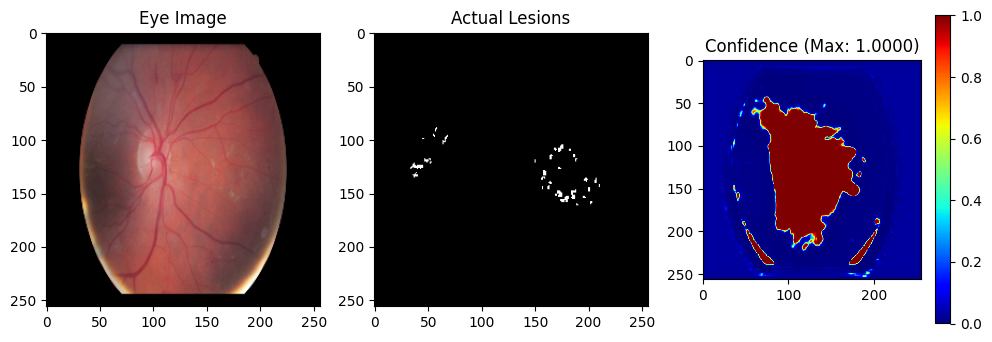

In [13]:
preds = model.predict(X_val)

for i in range(len(X_val)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(X_val[i]); plt.title("Eye Image")
    plt.subplot(1, 3, 2); plt.imshow(y_val[i].squeeze(), cmap='gray'); plt.title("Actual Lesions")
    
    # The 'jet' map shows the model's 'best guess' in color
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze(), cmap='jet')
    plt.colorbar()
    plt.title(f"Confidence (Max: {np.max(preds[i]):.4f})")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


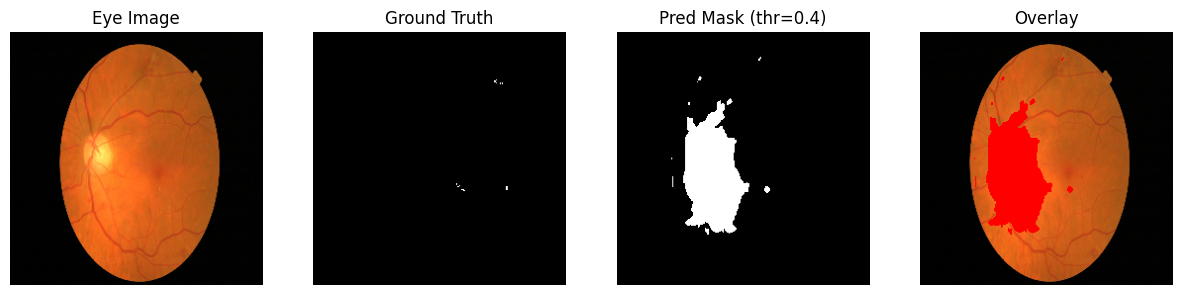

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


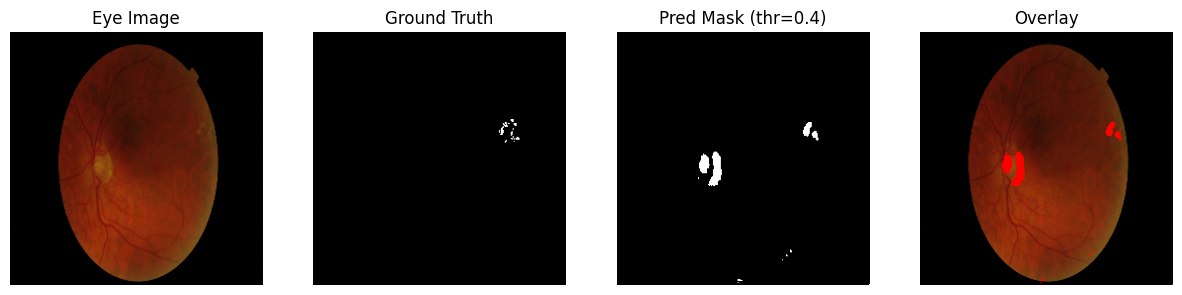

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


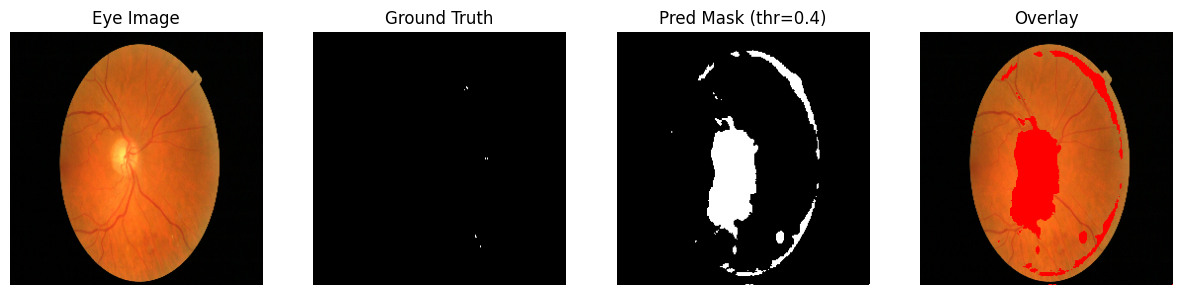

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


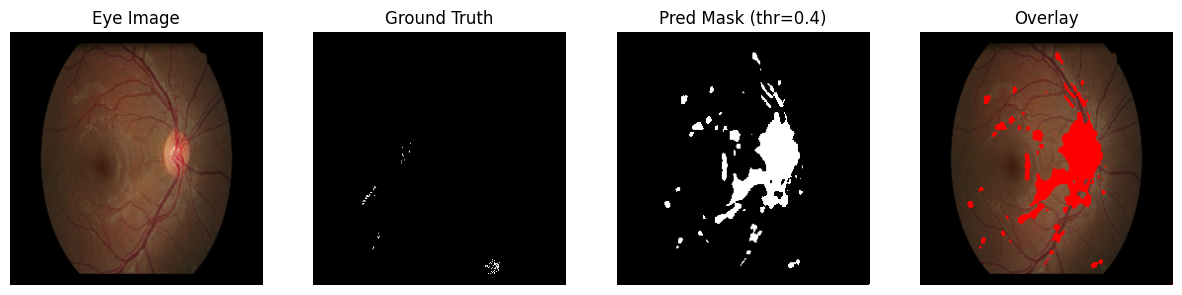

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


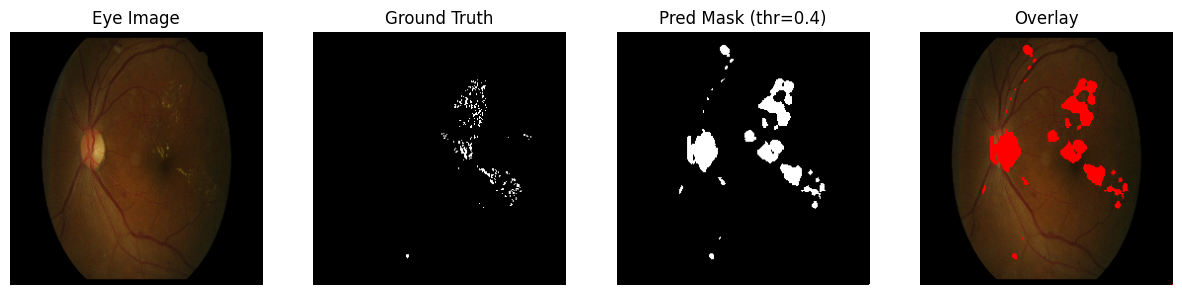

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


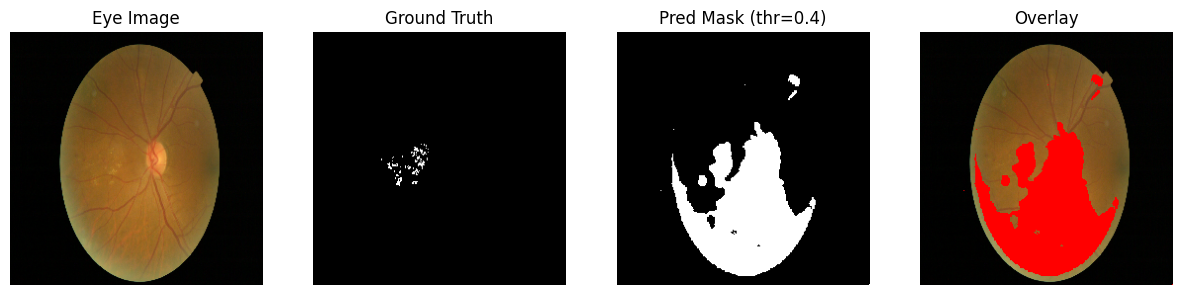

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


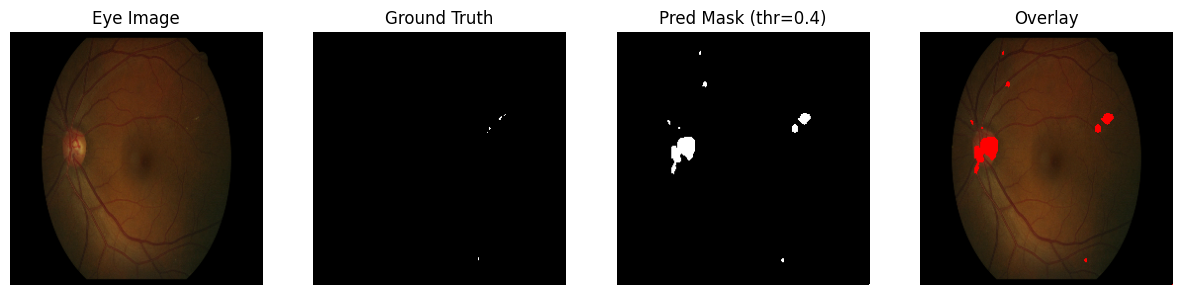

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


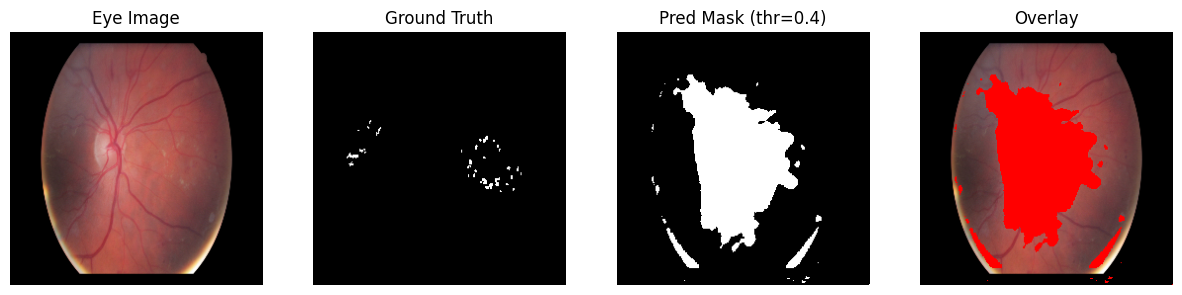

In [18]:
import cv2

pred_mask = cv2.medianBlur(pred_mask.astype(np.uint8)*255, 5)
pred_mask = (pred_mask > 0).astype(np.uint8)


preds = model.predict(X_val)

threshold = 0.4   


for i in range(len(X_val)):
    
    pred_prob = preds[i].squeeze()
    pred_mask = (pred_prob > threshold).astype(np.uint8)
    true_mask = y_val[i].squeeze()

    # Create overlay
    overlay = X_val[i].copy()
    overlay[pred_mask == 1] = [255, 0, 0]   # red highlight

    plt.figure(figsize=(15,4))

    plt.subplot(1,4,1)
    plt.imshow(X_val[i])
    plt.title("Eye Image")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title(f"Pred Mask (thr={threshold})")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()
